In [1]:
import sys
import os
import json
from PIL import Image
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torchvision.ops as ops
import math
import random
from dotenv import load_dotenv

load_dotenv()
YT_ROOTS = [os.getenv("YT_ROOT_1"), os.getenv("YT_ROOT_2")]


def extract_bbox_from_points(points):
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    x1, x2 = min(xs), max(xs)
    y1, y2 = min(ys), max(ys)
    return [x1, y1, x2 - x1, y2 - y1]  # x, y, w, h


def get_brake_status(raw):
    if "BrakeOn" in raw:
        return "brake_on"
    if "BrakeOff" in raw:
        return "brake_off"
    return "unknown"


def get_turn_signal(ts):
    if ts == "left":
        return "left_signal"
    if ts == "right":
        return "right_signal"
    if ts == "hazard":
        return "hazard"
    if ts == "off":
        return "off"
    return "unknown"


def normalize_label(shape):
    raw = shape["label"]
    ts = shape.get("attributes", {}).get("turn_signal", "")
    return get_brake_status(raw), get_turn_signal(ts)


def process_json(json_path):
    img_path = json_path[:-5] + ".jpg"
    if not os.path.exists(img_path):
        return None

    try:
        with open(json_path, "r") as f:
            ann = json.load(f)
    except:
        return None

    objects = []
    for shape in ann.get("shapes", []):
        bbox = extract_bbox_from_points(shape["points"])
        brake_status, turn_signal = normalize_label(shape)
        if brake_status != "unknown":
            objects.append({"bbox": bbox, "label": brake_status})
        if turn_signal not in ["unknown", "off"]:
            objects.append({"bbox": bbox, "label": turn_signal})

    return {"image_path": img_path, "objects": objects}


def load_yt_dataset_fast(root_dirs, max_workers=16):
    json_files = [
        os.path.join(dirpath, f)
        for root in root_dirs
        for dirpath, _, filenames in os.walk(root)
        for f in filenames
        if f.lower().endswith(".json")
    ]
    print("finished finding all JSON files")

    samples = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_json, jf): jf for jf in json_files}
        for idx, future in enumerate(as_completed(futures)):
            res = future.result()
            if res:
                samples.append(res)
            if (idx + 1) % 1000 == 0:
                print(f"Processed {idx+1} / {len(json_files)} JSON files")

    return samples

In [2]:
print('starting to load YT dataset...')
samples = load_yt_dataset_fast(YT_ROOTS)
print("Total samples:", len(samples))


starting to load YT dataset...
finished finding all JSON files
Processed 1000 / 111800 JSON files
Processed 2000 / 111800 JSON files
Processed 3000 / 111800 JSON files
Processed 4000 / 111800 JSON files
Processed 5000 / 111800 JSON files
Processed 6000 / 111800 JSON files
Processed 7000 / 111800 JSON files
Processed 8000 / 111800 JSON files
Processed 9000 / 111800 JSON files
Processed 10000 / 111800 JSON files
Processed 11000 / 111800 JSON files
Processed 12000 / 111800 JSON files
Processed 13000 / 111800 JSON files
Processed 14000 / 111800 JSON files
Processed 15000 / 111800 JSON files
Processed 16000 / 111800 JSON files
Processed 17000 / 111800 JSON files
Processed 18000 / 111800 JSON files
Processed 19000 / 111800 JSON files
Processed 20000 / 111800 JSON files
Processed 21000 / 111800 JSON files
Processed 22000 / 111800 JSON files
Processed 23000 / 111800 JSON files
Processed 24000 / 111800 JSON files
Processed 25000 / 111800 JSON files
Processed 26000 / 111800 JSON files
Processed 

In [3]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
model.to(device)
model.eval()

OwlViTForObjectDetection(
  (owlvit): OwlViTModel(
    (text_model): OwlViTTextTransformer(
      (embeddings): OwlViTTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(16, 512)
      )
      (encoder): OwlViTEncoder(
        (layers): ModuleList(
          (0-11): 12 x OwlViTEncoderLayer(
            (self_attn): OwlViTAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): OwlViTMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_

Where does OWL-ViT fail in this safety-critical scenario?


In [4]:
label_map = {
    "brake_off": "car with brake light off",
    "brake_on": "car with brake light on",
    "left_signal": "car with left signal on",
    "right_signal": "car with right signal on",
    "hazard": "car with hazard lights on",
}

text_queries = list(label_map.values())
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
label_to_idx = {key: idx for idx, key in enumerate(label_map.keys())}


class OwlViTDataset(Dataset):
    def __init__(self, records, label_map, min_boxes=1):
        self.label_map = label_map
        self.records = [
            record
            for record in records
            if sum(obj["label"] in label_map for obj in record["objects"]) >= min_boxes
        ]
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        item = self.records[idx]
        img_path = item["image_path"]
        objects = item["objects"]

        image = Image.open(img_path).convert("RGB")
        width, height = image.size

        boxes = []
        labels_idx = []
        for obj in objects:
            class_name = obj["label"]
            if class_name not in self.label_map:
                continue

            x, y, w, h = obj["bbox"]
            x1 = max(x / width, 0.0)
            y1 = max(y / height, 0.0)
            x2 = min((x + w) / width, 1.0)
            y2 = min((y + h) / height, 1.0)

            boxes.append([float(x1), float(y1), float(x2), float(y2)])
            labels_idx.append(self.label_to_idx[class_name])

        if boxes:
            boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        else:
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)

        if labels_idx:
            labels_tensor = torch.tensor(labels_idx, dtype=torch.long)
        else:
            labels_tensor = torch.zeros((0,), dtype=torch.long)

        return {
            "image": image,
            "boxes": boxes_tensor,
            "labels": labels_tensor,
            "image_path": img_path,
            "size": (height, width),
        }

In [5]:
def train_val_split(records, train_ratio=0.85, seed=42):
    indices = list(range(len(records)))
    random.Random(seed).shuffle(indices)
    split_idx = max(1, int(len(indices) * train_ratio))
    train_records = [records[i] for i in indices[:split_idx]]
    val_records = [records[i] for i in indices[split_idx:]]
    if not val_records:
        val_records = train_records[-1:]
        train_records = train_records[:-1]
    return train_records, val_records


def owlvit_collate_fn(batch):
    images = [item["image"] for item in batch]
    batch_text = [text_queries] * len(images)
    encoded = processor(images=images, text=batch_text, return_tensors="pt", padding=True)

    return {
        "pixel_values": encoded["pixel_values"],
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"],
        "gt_boxes": [item["boxes"] for item in batch],
        "gt_labels": [item["labels"] for item in batch],
        "image_paths": [item["image_path"] for item in batch],
    }


def cxcywh_to_xyxy(boxes):
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    return torch.stack([x1, y1, x2, y2], dim=-1)


def xyxy_to_cxcywh(boxes):
    x1, y1, x2, y2 = boxes.unbind(-1)
    w = x2 - x1
    h = y2 - y1
    cx = x1 + 0.5 * w
    cy = y1 + 0.5 * h
    return torch.stack([cx, cy, w, h], dim=-1)


def owlvit_detection_loss(outputs, gt_boxes, gt_labels, cls_weight=1.0, box_weight=2.0, iou_weight=1.0):
    pred_boxes = outputs.pred_boxes
    pred_logits = outputs.logits
    device = pred_boxes.device
    total_loss = torch.zeros(1, device=device)
    matched_batches = 0

    for batch_idx in range(len(gt_boxes)):
        boxes = gt_boxes[batch_idx].to(device)
        labels = gt_labels[batch_idx].to(device)
        if boxes.numel() == 0:
            continue

        preds_xyxy = cxcywh_to_xyxy(pred_boxes[batch_idx])
        ious = ops.box_iou(preds_xyxy, boxes)
        best_idx = torch.argmax(ious, dim=0)
        matched_logits = pred_logits[batch_idx][best_idx]
        cls_loss = F.cross_entropy(matched_logits, labels)

        pred_cxcywh = pred_boxes[batch_idx][best_idx]
        target_cxcywh = xyxy_to_cxcywh(boxes)
        box_loss = F.l1_loss(pred_cxcywh, target_cxcywh)

        matched_ious = ious[best_idx, torch.arange(len(boxes), device=device)]
        iou_loss = (1.0 - matched_ious.clamp(0.0, 1.0)).mean()

        total_loss = total_loss + cls_weight * cls_loss + box_weight * box_loss + iou_weight * iou_loss
        matched_batches += 1

    if matched_batches == 0:
        return total_loss

    return total_loss / matched_batches

In [6]:
train_records, val_records = train_val_split(samples, train_ratio=0.70, seed=42)
train_dataset = OwlViTDataset(train_records, label_map)
val_dataset = OwlViTDataset(val_records, label_map)

print(f"Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)}")

Train samples: 54409 | Val samples: 23344


In [7]:
batch_size = 16
num_epochs = 4
learning_rate = 5e-6
weight_decay = 0.01
grad_clip = 1.0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=owlvit_collate_fn,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=owlvit_collate_fn,
    num_workers=0,
)

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
total_train_steps = max(1, len(train_loader) * num_epochs)
scheduler = CosineAnnealingLR(optimizer, T_max=total_train_steps)

In [11]:
def run_epoch(data_loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    epoch_loss = 0.0
    steps = 0
    loop = tqdm(data_loader, desc="train" if train else "val", leave=False)

    for batch in loop:
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                attention_mask=attention_mask,
            )
            loss = owlvit_detection_loss(
                outputs,
                gt_boxes=batch["gt_boxes"],
                gt_labels=batch["gt_labels"],
            )

            if train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()

        epoch_loss += loss.item()
        steps += 1
        loop.set_postfix(loss=epoch_loss / max(1, steps))

    return epoch_loss / max(1, steps)


for epoch in range(num_epochs):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch + 1}/{num_epochs} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")

train:   0%|          | 0/3401 [00:00<?, ?it/s]

val:   0%|          | 0/1460 [00:00<?, ?it/s]

Epoch 1/4 | train loss: 0.4499 | val loss: 0.3777


train:   0%|          | 0/3401 [00:00<?, ?it/s]

val:   0%|          | 0/1460 [00:00<?, ?it/s]

Epoch 2/4 | train loss: 0.3202 | val loss: 0.3385


train:   0%|          | 0/3401 [00:00<?, ?it/s]

val:   0%|          | 0/1460 [00:00<?, ?it/s]

Epoch 3/4 | train loss: 0.2547 | val loss: 0.3320


train:   0%|          | 0/3401 [00:00<?, ?it/s]

val:   0%|          | 0/1460 [00:00<?, ?it/s]

Epoch 4/4 | train loss: 0.2199 | val loss: 0.3324


In [ ]:
save_dir = os.path.join("artifacts", f"owlvit-finetune")
os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)
print(f"Saved fine-tuned OWL-ViT artifacts to {save_dir}")

Saved fine-tuned OWL-ViT artifacts to artifacts\owlvit-finetune


In [8]:
ckpt_dir = "artifacts/owlvit-finetune" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

finetuned_processor = OwlViTProcessor.from_pretrained(ckpt_dir)
finetuned_model = OwlViTForObjectDetection.from_pretrained(ckpt_dir).to(device)
finetuned_model.eval()

OwlViTForObjectDetection(
  (owlvit): OwlViTModel(
    (text_model): OwlViTTextTransformer(
      (embeddings): OwlViTTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(16, 512)
      )
      (encoder): OwlViTEncoder(
        (layers): ModuleList(
          (0-11): 12 x OwlViTEncoderLayer(
            (self_attn): OwlViTAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): OwlViTMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_

In [ ]:
def visualize_owlvit_detections(
    processor,
    model,
    image,
    text_queries,
    threshold: float = 0.1,
    device=None,
    figsize=(12, 8),
):
    if isinstance(image, (str, bytes, os.PathLike)):
        image = Image.open(image).convert("RGB")

    device = device or next(model.parameters()).device

    inputs = processor(text=text_queries, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = torch.tensor([(image.height, image.width)], device=device)

    result = processor.post_process_grounded_object_detection(
        outputs=outputs,
        target_sizes=target_sizes,
        threshold=float(threshold),
        text_labels=[text_queries],
    )[0]

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(image)

    if "boxes" in result and len(result["boxes"]) > 0:
        boxes = result["boxes"].detach().cpu()
        scores = result["scores"].detach().cpu()
        labels = result["labels"].detach().cpu()

        for box, score, label_idx in zip(boxes, scores, labels):
            x1, y1, x2, y2 = box.tolist()
            w, h = x2 - x1, y2 - y1
            rect = patches.Rectangle(
                (x1, y1), w, h, linewidth=2, edgecolor="lime", facecolor="none"
            )
            ax.add_patch(rect)
            label_text = f"{text_queries[int(label_idx)]}: {score:.2f}"
            ax.text(
                x1,
                max(0, y1 - 5),
                label_text,
                fontsize=9,
                color="black",
                bbox=dict(facecolor="yellow", alpha=0.5, edgecolor="none"),
            )
    else:
        ax.set_title(f"No detections above threshold={threshold}")

    ax.axis("off")
    plt.show()

Image: D:\TLD-YT-part1\DiWh2CmZRL4\DiWh2CmZRL4-part2\000000970.jpg
Pretrained model detections:


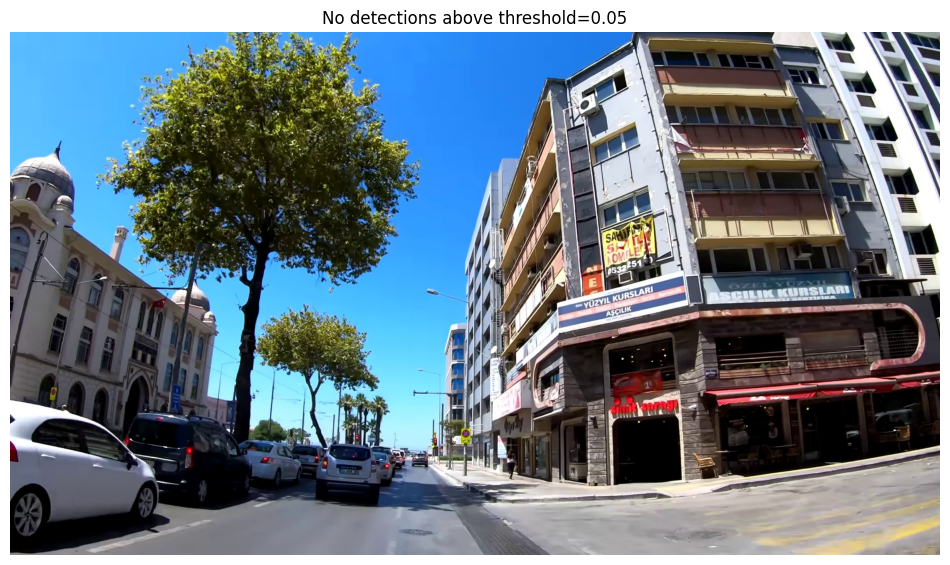

Fine-tuned model detections:


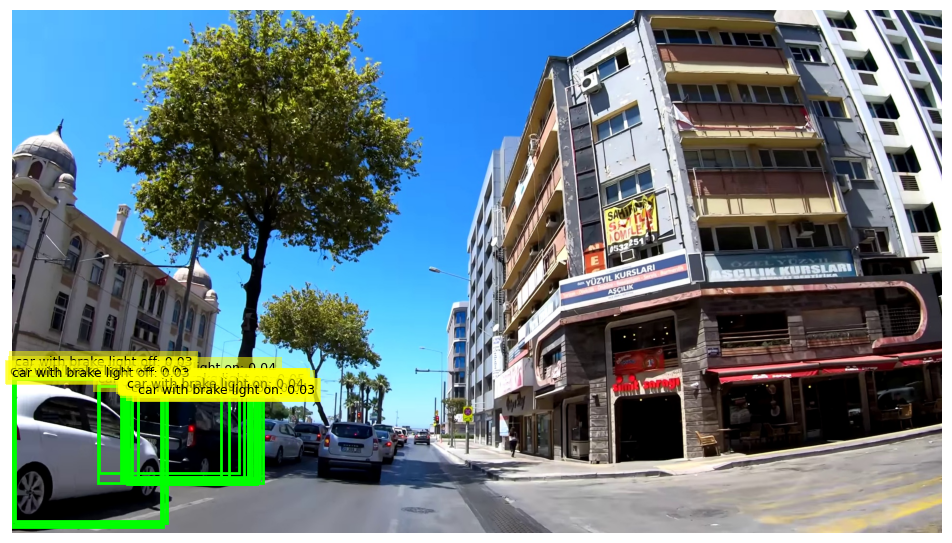

Image: D:\TLD-YT-part1\D_k-Tfr1JsQ\D_k-Tfr1JsQ-part10\000005402.jpg
Pretrained model detections:


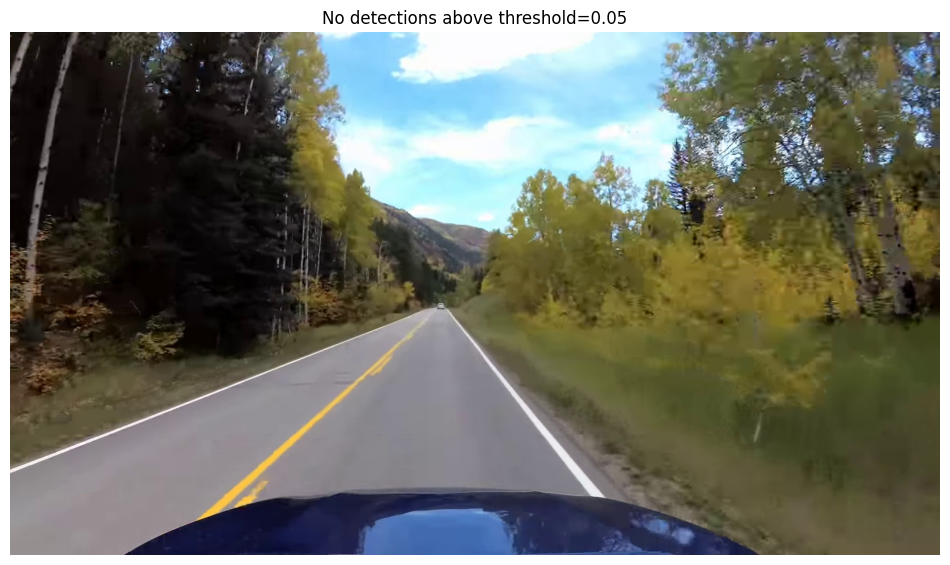

Fine-tuned model detections:


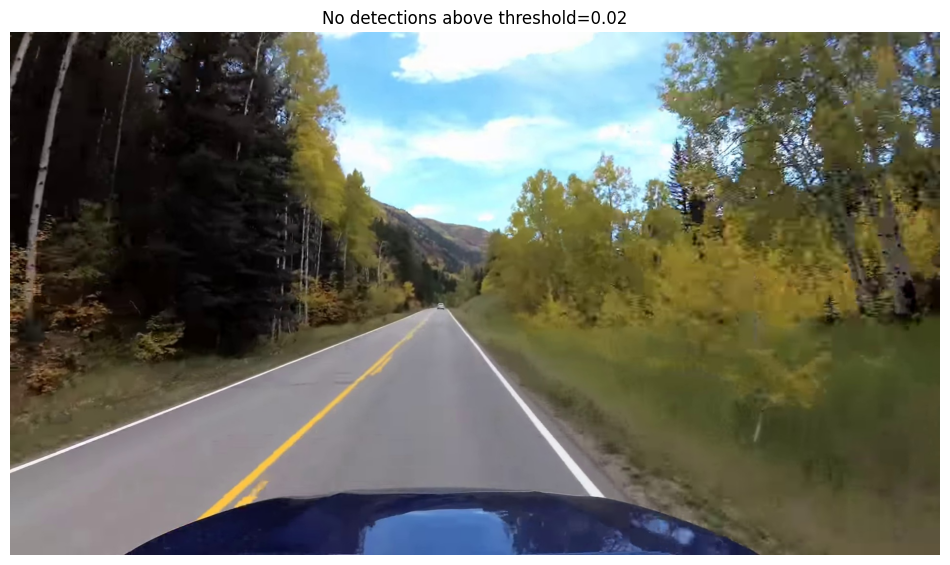

Image: D:\TLD-YT-part1\Chhs6fUP8so\Chhs6fUP8so-part4\000002376.jpg
Pretrained model detections:


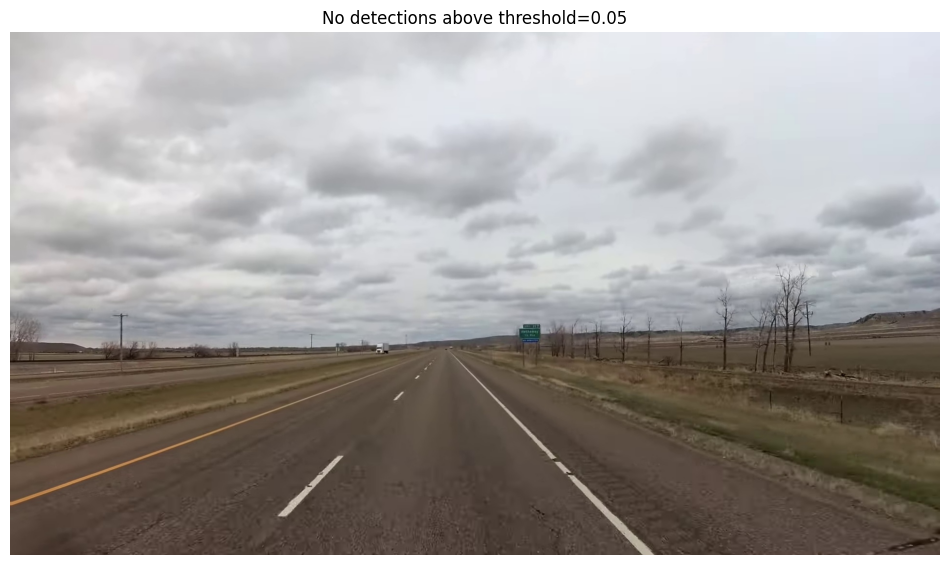

Fine-tuned model detections:


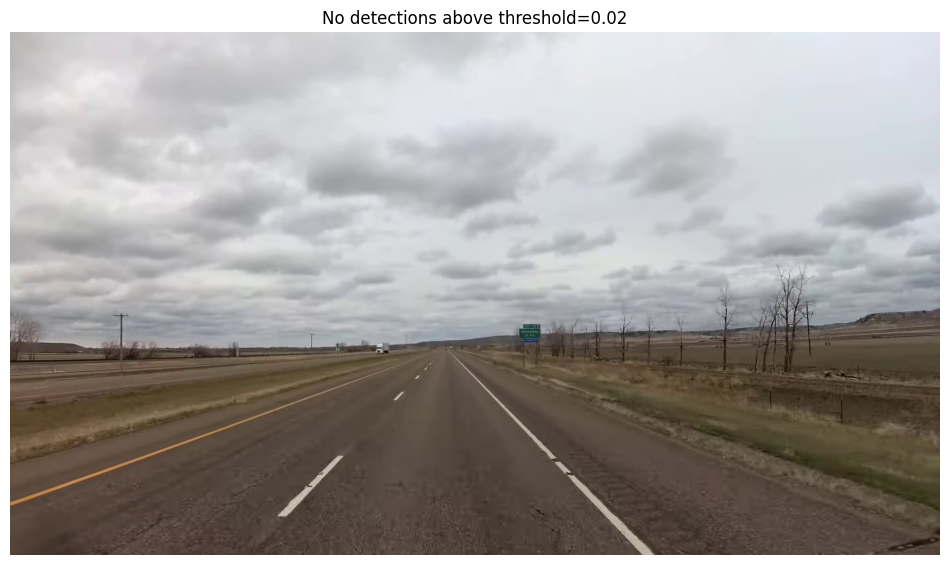

Image: D:\TLD-YT-part1\DnDh8ewZdT4\DnDh8ewZdT4-part2\000000179.jpg
Pretrained model detections:


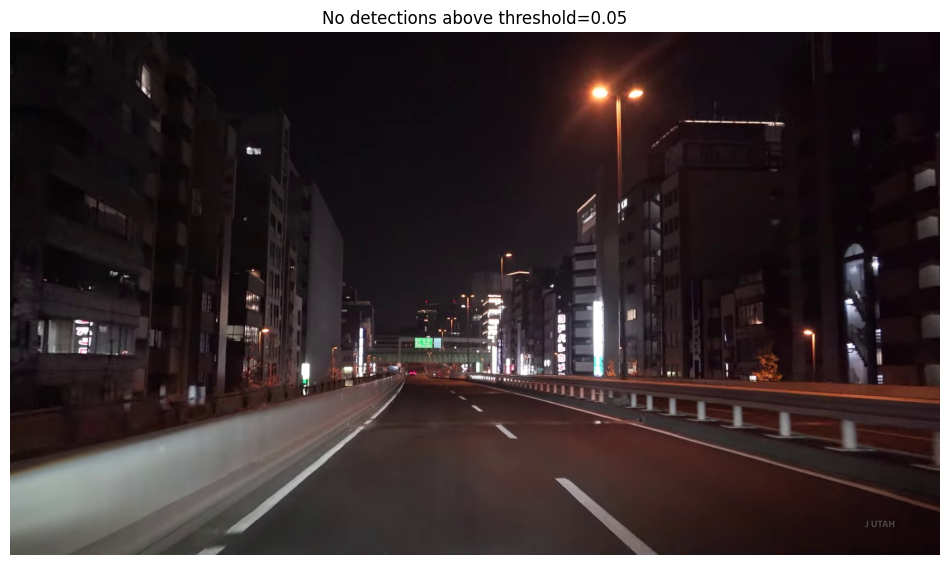

Fine-tuned model detections:


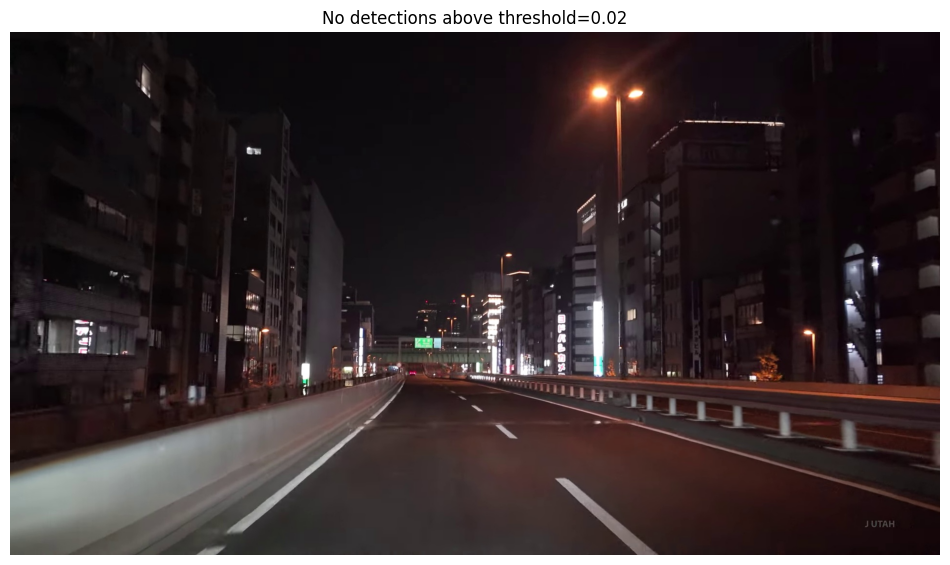

Image: D:\TLD-YT-part1\Cmp39Cd3t7I\Cmp39Cd3t7I-part5\000002446.jpg
Pretrained model detections:


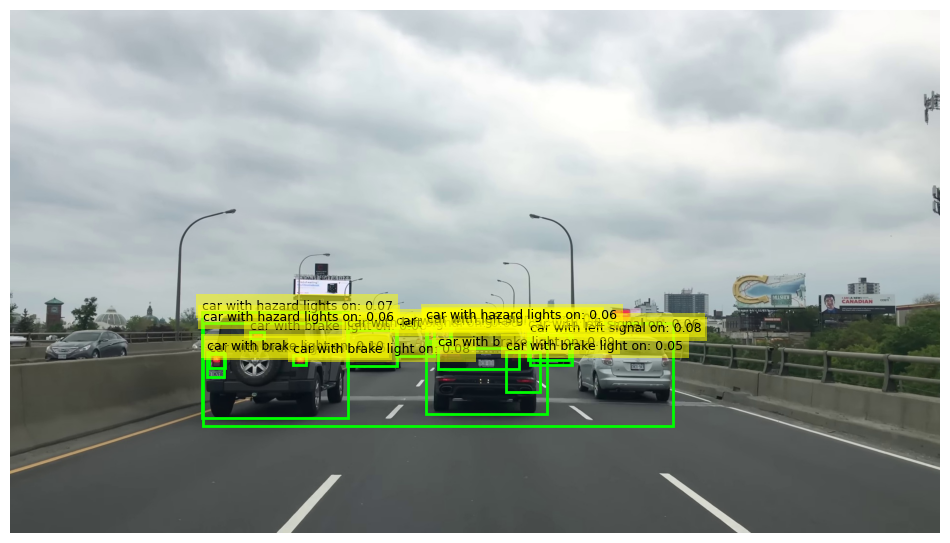

Fine-tuned model detections:


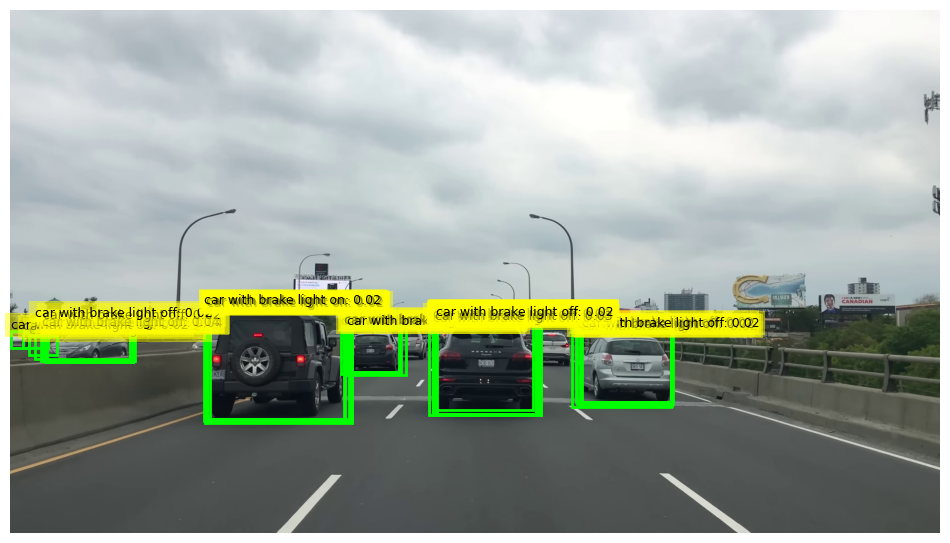

In [19]:
image_paths = [rec["image_path"] for rec in train_records[:5]]

for img_path in image_paths:
    image = Image.open(img_path).convert("RGB")
    print(f"Image: {img_path}")

    print("Pretrained model detections:")
    visualize_owlvit_detections(
        processor=processor,
        model=model,
        image=image,
        text_queries=text_queries,
        threshold=0.05,
    )

    print("Fine-tuned model detections:")
    visualize_owlvit_detections(
        processor=finetuned_processor,
        model=finetuned_model,
        image=image,
        text_queries=text_queries,
        threshold=0.02,
    )
